# Add various kinds of noise then test denoising methods

In [32]:
import cv2
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def load_image_keep_channels(path):
    # preserve number of channels and alpha if present
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(path)
    # convert 4-channel BGRA -> BGR (drop alpha) for metric comparisons
    if img.ndim == 3 and img.shape[2] == 4:
        img = img[:, :, :3]
    return img

def to_uint8(img):
    # convert floats to uint8 if needed (assume values in 0..1 for floats)
    if img.dtype == np.float32 or img.dtype == np.float64:
        img = np.clip(img, 0.0, 1.0)
        img = (img * 255).astype(np.uint8)
    else:
        img = img.astype(np.uint8)
    return img

def compute_metrics(ref_path, test_path):
    A = load_image_keep_channels(ref_path)
    B = load_image_keep_channels(test_path)

    # If either is grayscale image read as 2D, keep as 2D. If one is 2D and the other 3D,
    # convert 3D to grayscale to compare apples-to-apples (or replicate channels)
    if A.ndim == 2 and B.ndim == 3:
        B = cv2.cvtColor(B, cv2.COLOR_BGR2GRAY)
    elif A.ndim == 3 and B.ndim == 2:
        A = cv2.cvtColor(A, cv2.COLOR_BGR2GRAY)

    A = to_uint8(A)
    B = to_uint8(B)

    if A.shape != B.shape:
        raise ValueError(f"Shape mismatch: {A.shape} vs {B.shape}")

    # data_range for uint8 images
    data_range = 255 if A.dtype == np.uint8 else (A.max() - A.min())

    # PSNR works for both grayscale and color
    psnr_val = psnr(A, B, data_range=data_range)

    # For SSIM: specify channel_axis for multichannel arrays
    if A.ndim == 3:
        ssim_val = ssim(A, B, data_range=data_range, channel_axis=-1)
    else:
        ssim_val = ssim(A, B, data_range=data_range)

    return psnr_val, ssim_val

In [27]:
def AWGN(image, mean=0, sigma=25):
    """Add Additive White Gaussian Noise to an image (uint8 0–255)."""
    image = image.astype(np.float32)
    gauss = np.random.normal(mean, sigma, image.shape).astype(np.float32)
    noisy = image + gauss
    noisy = np.clip(noisy, 0, 255).astype(np.uint8)
    return noisy

def impulse_noise(image, prob=0.05):
    """Add Impulse Noise (Salt and Pepper Noise) to an image."""
    noisy_image = image.copy()
    black = 0
    white = 255
    probs = np.random.rand(*image.shape)
    noisy_image[probs < (prob / 2)] = black
    noisy_image[probs > 1 - (prob / 2)] = white
    return noisy_image

In [28]:
import os
import matplotlib.pyplot as plt
# add noise to image and save them to respective folders (AWGN and Impulse Noise)
def add_noise_and_save(input_image_path, awgn_folder, impulse_folder):
    if not os.path.exists(awgn_folder):
        os.makedirs(awgn_folder)
    if not os.path.exists(impulse_folder):
        os.makedirs(impulse_folder)

    image = load_image_keep_channels(input_image_path)

    awgn_image = AWGN(image)
    impulse_image = impulse_noise(image)

    awgn_image_path = os.path.join(awgn_folder, os.path.basename(input_image_path))
    impulse_image_path = os.path.join(impulse_folder, os.path.basename(input_image_path))

    cv2.imwrite(awgn_image_path, awgn_image)
    cv2.imwrite(impulse_image_path, impulse_image)

    return awgn_image_path, impulse_image_path



Image                PSNR_AWGN       SSIM_AWGN       PSNR_Impulse    SSIM_Impulse   
airplane.bmp         20.3544         0.2920          17.8858         0.3490         
boats.bmp            20.3560         0.3189          18.3726         0.3466         
BoatsColor.bmp       20.5001         0.3354          18.1472         0.3672         
checkerboard.bmp     23.1995         0.2957          15.9208         0.4216         
goldhill.bmp         20.4580         0.3402          17.9982         0.3766         


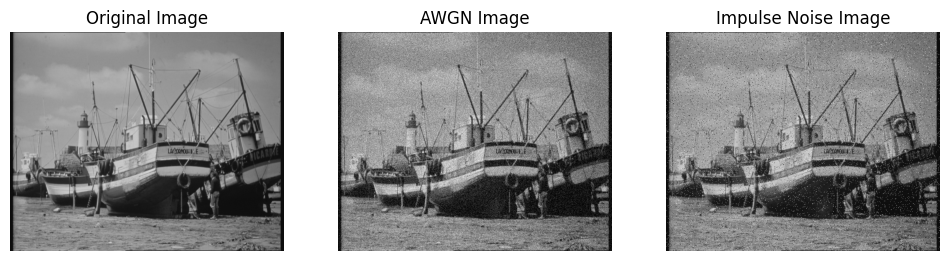

In [31]:
# add noise to all the .bmp images in STI/Classic
input_folder = 'C:\\ImageProcessing\\Project_5\\original'
awgn_folder = 'C:\\ImageProcessing\\Project_5\\noisy_images\\AWGN'
impulse_folder = 'C:\\ImageProcessing\\Project_5\\noisy_images\\Impulse'
for filename in os.listdir(input_folder):
    if filename.endswith('.bmp'):
        input_image_path = os.path.join(input_folder, filename)
        add_noise_and_save(input_image_path, awgn_folder, impulse_folder)

#calculate PSNR and SSIM for noisy images
results = []
for filename in os.listdir(input_folder):
    if filename.endswith('.bmp'):
        input_image_path = os.path.join(input_folder, filename)
        awgn_image_path = os.path.join(awgn_folder, filename)
        impulse_image_path = os.path.join(impulse_folder, filename)

        psnr_awgn, ssim_awgn = compute_metrics(input_image_path, awgn_image_path)
        psnr_impulse, ssim_impulse = compute_metrics(input_image_path, impulse_image_path)

        results.append((filename, psnr_awgn, ssim_awgn, psnr_impulse, ssim_impulse))
# Print results in tabular format
print(f"{'Image':<20} {'PSNR_AWGN':<15} {'SSIM_AWGN':<15} {'PSNR_Impulse':<15} {'SSIM_Impulse':<15}")
for row in results:
    print(f"{row[0]:<20} {row[1]:<15.4f} {row[2]:<15.4f} {row[3]:<15.4f} {row[4]:<15.4f}")

# Visualize one example
example_image = os.path.join(input_folder, 'boats.bmp')
awgn_image_path = os.path.join(awgn_folder, 'boats.bmp')
impulse_image_path = os.path.join(impulse_folder, 'boats.bmp')
original = load_image_keep_channels(example_image)
awgn_image = load_image_keep_channels(awgn_image_path)
impulse_image = load_image_keep_channels(impulse_image_path)
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title('AWGN Image')
plt.imshow(cv2.cvtColor(awgn_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title('Impulse Noise Image')
plt.imshow(cv2.cvtColor(impulse_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [ ]:
boats_path = 'C:\\ImageProcessing\\Project_5\\original\\boats.bmp'
for i in range(1, 30, 5):
    noisy_image = AWGN(load_image_keep_channels(boats_path), sigma=i)
    noisy_image_path = f'C:\\ImageProcessing\\Project_5\\noisy_images\\AWGN\\boats_sigma_{i}.bmp'
    cv2.imwrite(noisy_image_path, noisy_image)
    psnr_val, ssim_val = compute_metrics(boats_path, noisy_image_path)
    print(f'Sigma: {i}, PSNR: {psnr_val:.2f}, SSIM: {ssim_val:.4f}')
    

Sigma: 1, PSNR: 46.88, SSIM: 0.9913
Sigma: 3, PSNR: 38.43, SSIM: 0.9345
Sigma: 5, PSNR: 34.10, SSIM: 0.8472
Sigma: 7, PSNR: 31.22, SSIM: 0.7548
Sigma: 9, PSNR: 29.06, SSIM: 0.6707
Sigma: 11, PSNR: 27.35, SSIM: 0.5992
Sigma: 13, PSNR: 25.91, SSIM: 0.5382
Sigma: 15, PSNR: 24.69, SSIM: 0.4865
Sigma: 17, PSNR: 23.63, SSIM: 0.4428
Sigma: 19, PSNR: 22.66, SSIM: 0.4038
Sigma: 21, PSNR: 21.83, SSIM: 0.3723
Sigma: 23, PSNR: 21.06, SSIM: 0.3440
Sigma: 25, PSNR: 20.36, SSIM: 0.3184
Sigma: 27, PSNR: 19.72, SSIM: 0.2970
Sigma: 29, PSNR: 19.10, SSIM: 0.2767
